In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
heart_df=pd.read_csv("data/framingham.csv")
heart_df.drop(['education'],axis=1,inplace=True)
heart_df.head()

,male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [4]:
heart_df.rename(columns={'male':'Sex_male'},inplace=True)

In [6]:
heart_df.isnull().sum()/len(heart_df)

Sex_male           0.000000
age                0.000000
currentSmoker      0.000000
cigsPerDay         0.006840
BPMeds             0.012500
prevalentStroke    0.000000
prevalentHyp       0.000000
diabetes           0.000000
totChol            0.011792
sysBP              0.000000
diaBP              0.000000
BMI                0.004481
heartRate          0.000236
glucose            0.091509
TenYearCHD         0.000000
dtype: float64

In [7]:
heart_df.dropna(axis=0,inplace=True)

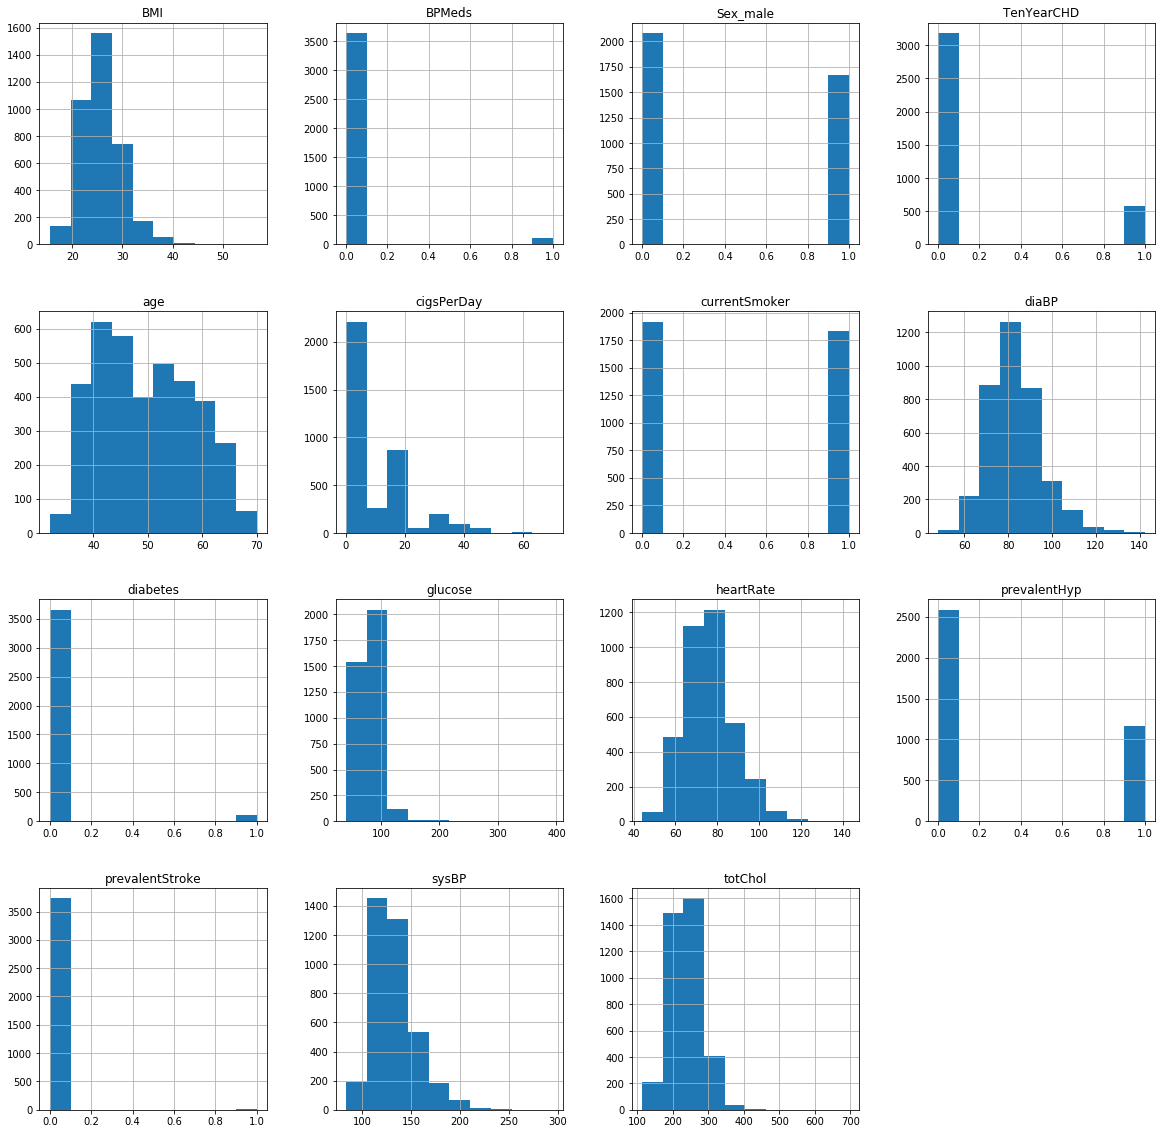

In [8]:
heart_df.hist(figsize=(20, 20));

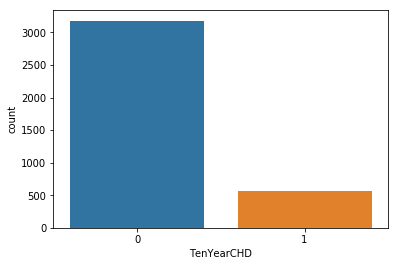

In [10]:
sns.countplot(x='TenYearCHD',data=heart_df);

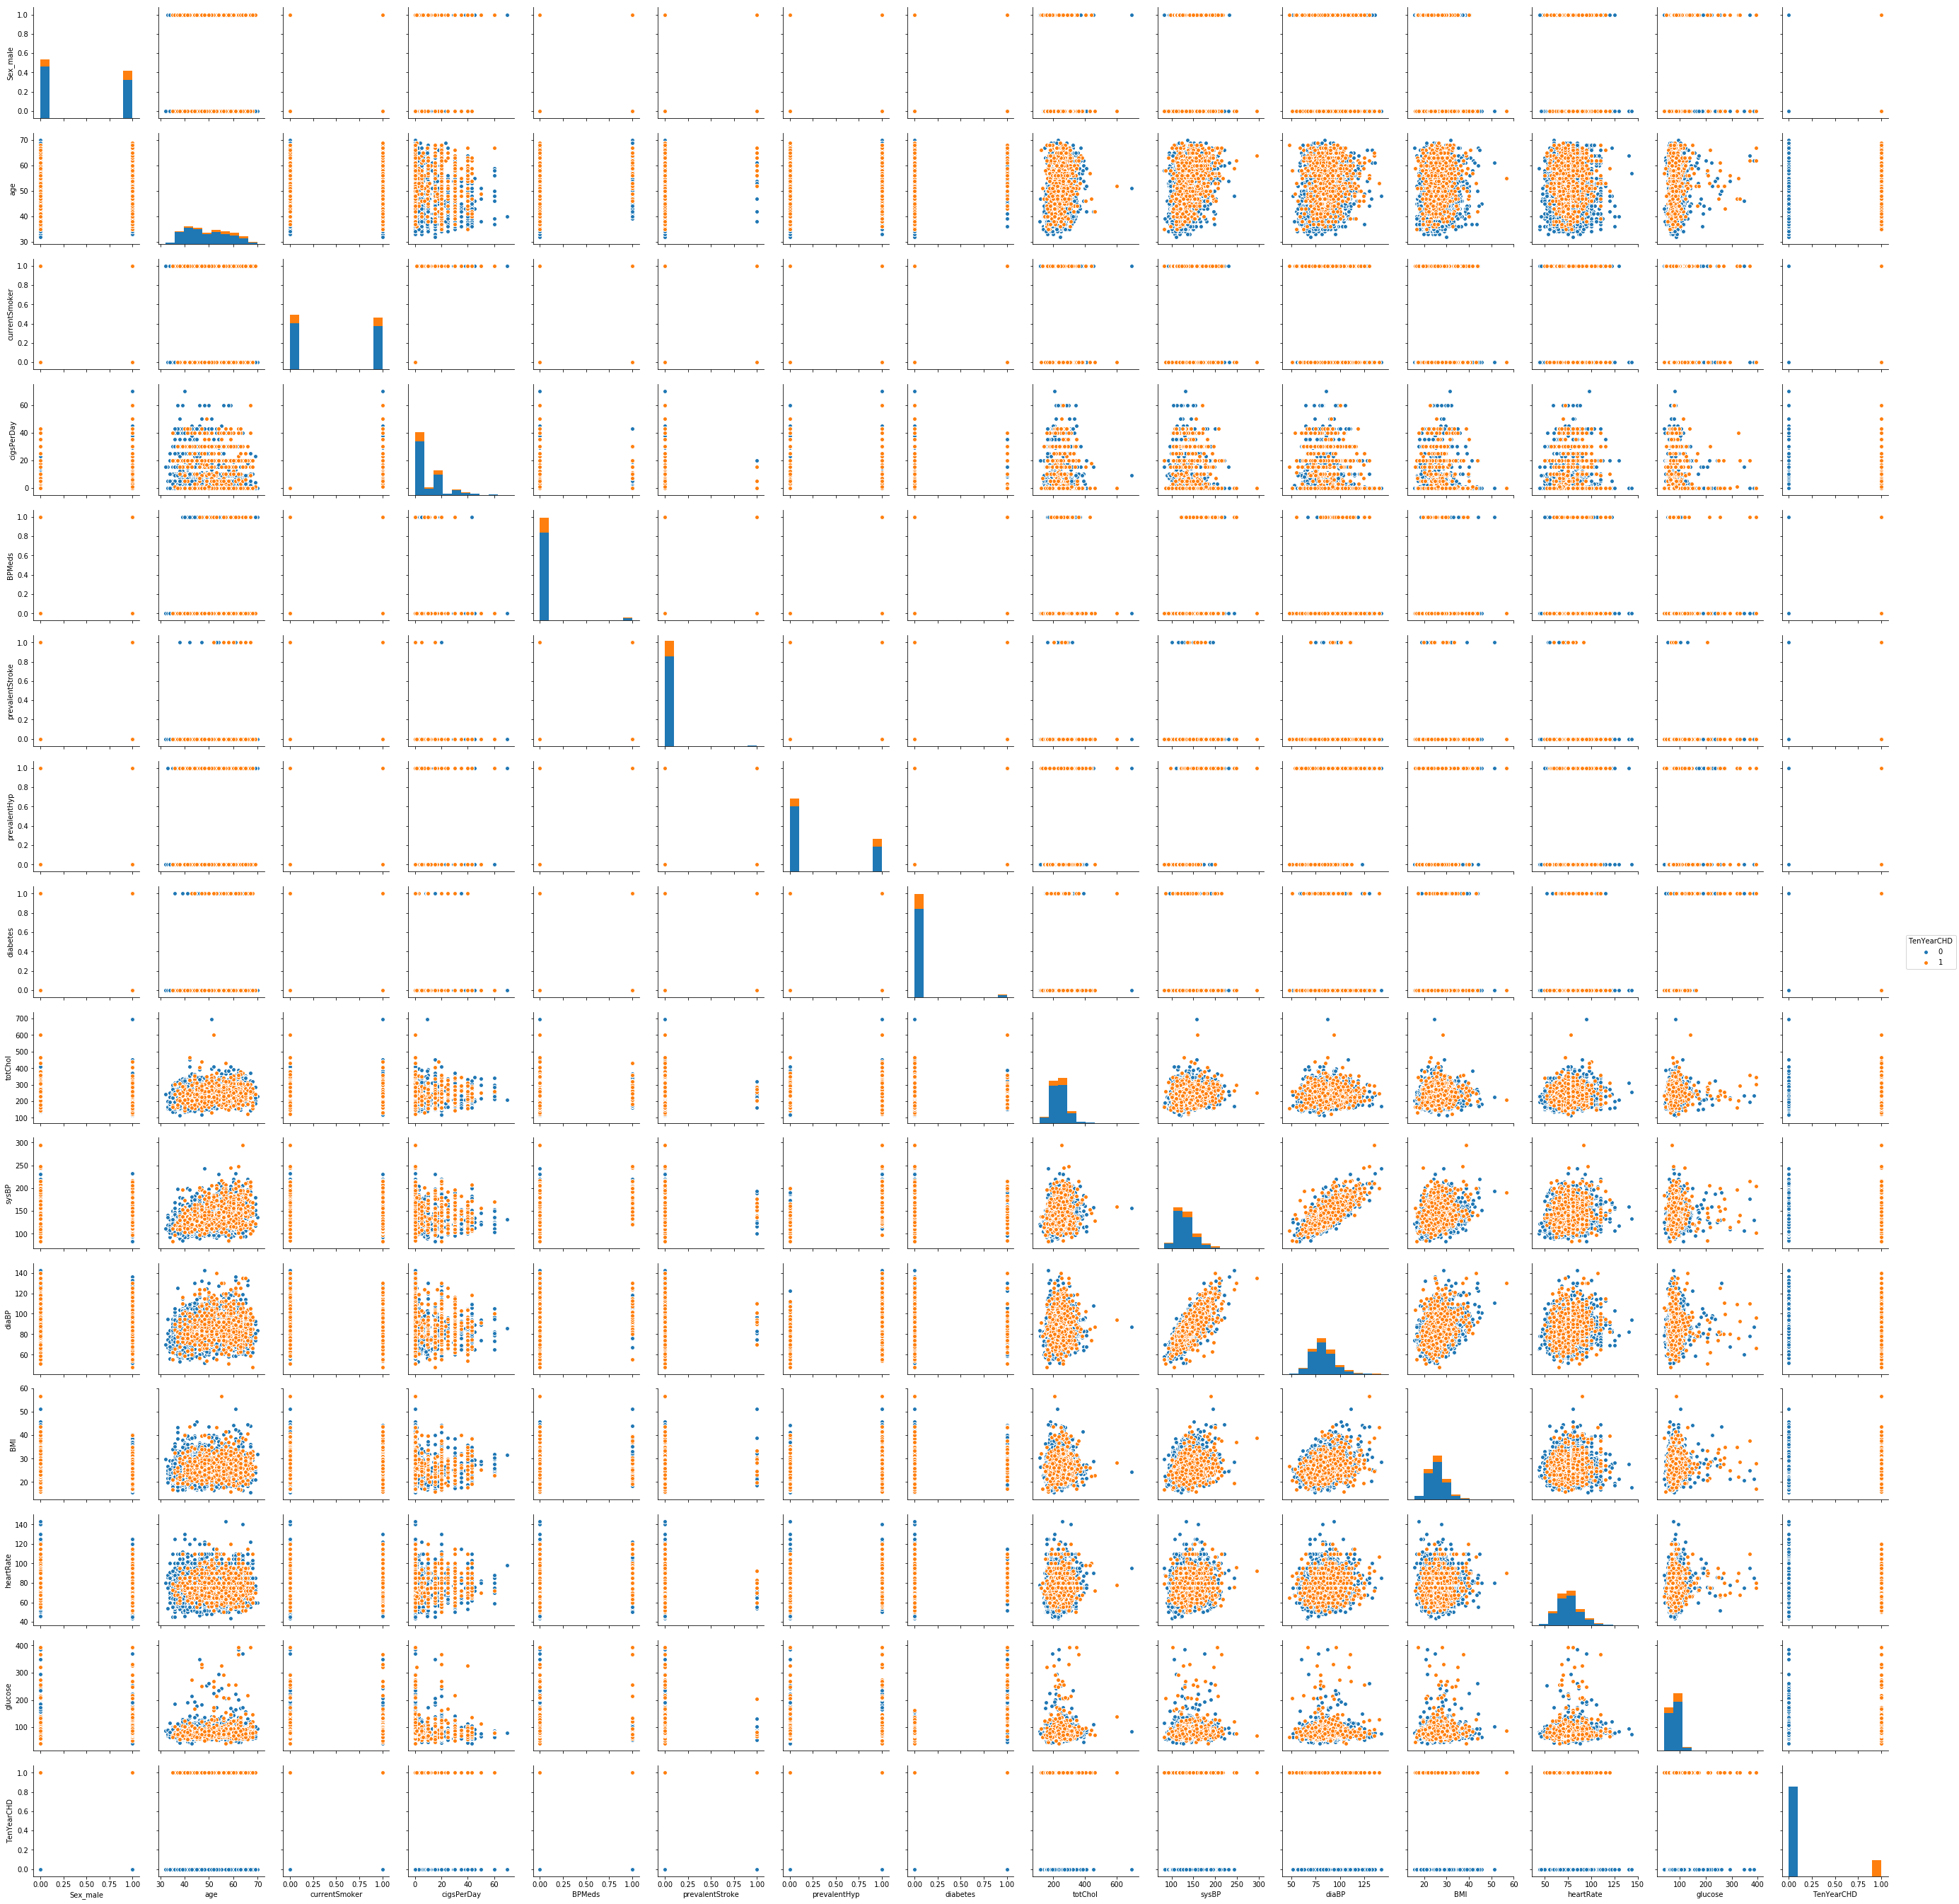

In [11]:
sns.pairplot(data=heart_df, hue='TenYearCHD')

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [14]:
def quality_report(prediction, actual):
    print("Accuracy: {:.3f}\nPrecision: {:.3f}\nRecall: {:.3f}\nf1_score: {:.3f}".format(
        accuracy_score(prediction, actual),
        precision_score(prediction, actual),
        recall_score(prediction, actual),
        f1_score(prediction, actual)
    ))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    heart_df.drop(['TenYearCHD'], axis=1), 
    heart_df['TenYearCHD'], 
    test_size=0.20, 
    random_state=42, 
    stratify=heart_df['TenYearCHD']
)

# стандартизируем
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
log_reg = LogisticRegression()

log_reg.fit(X_train_scaled, y_train)
print("Train quality:")
quality_report(log_reg.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(log_reg.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.855
Precision: 0.101
Recall: 0.657
f1_score: 0.175

Test quality:
Accuracy: 0.847
Precision: 0.043
Recall: 0.500
f1_score: 0.080


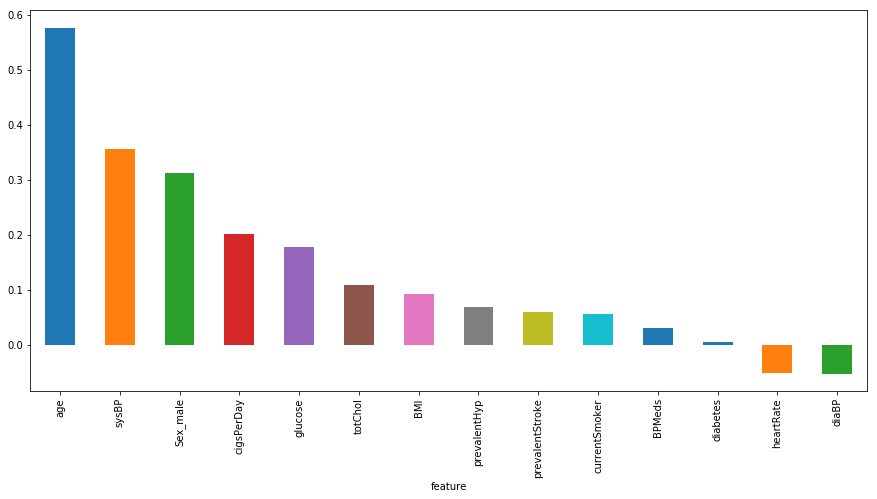

In [17]:
featureImportance = pd.DataFrame({"feature": heart_df.drop('TenYearCHD',axis=1).columns, 
                                  "importance": log_reg.coef_[0]})

featureImportance.set_index('feature', inplace=True)
featureImportance.sort_values(["importance"], ascending=False, inplace=True)
featureImportance["importance"].plot('bar', figsize=(15, 7));

In [18]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc_curve(prob_prediction, actual):
    fpr, tpr, thresholds = roc_curve(y_test, prob_prediction)
    auc_score = roc_auc_score(y_test, prob_prediction)
    
    plt.plot(fpr, tpr, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC: {:.3f}'.format(auc_score))
    plt.show()

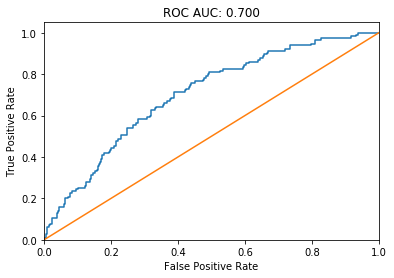

In [19]:
plot_roc_curve(log_reg.predict_proba(X_test_scaled)[:,1], y_test)

In [20]:
log_reg_cv = LogisticRegressionCV(Cs=100)
log_reg_cv.fit(X_train_scaled, y_train)
print("Train quality:")
quality_report(log_reg_cv.predict(X_train_scaled), y_train)
print("\nTest quality:")
quality_report(log_reg_cv.predict(X_test_scaled), y_test)

Train quality:
Accuracy: 0.855
Precision: 0.083
Recall: 0.717
f1_score: 0.149

Test quality:
Accuracy: 0.844
Precision: 0.026
Recall: 0.375
f1_score: 0.049


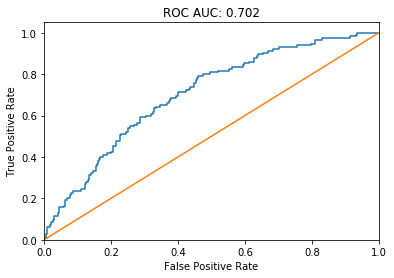

In [21]:
plot_roc_curve(log_reg_cv.predict_proba(X_test_scaled)[:,1], y_test)

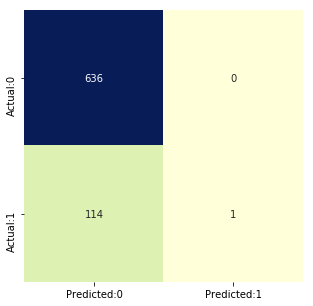

In [27]:
from sklearn.metrics import confusion_matrix

#

cm = confusion_matrix(y_test, log_reg_cv.predict_proba(X_test_scaled)[:, 1]>0.8)

conf_matrix = pd.DataFrame(data = cm, columns = ['Predicted:0','Predicted:1'], index=['Actual:0','Actual:1'])
plt.figure(figsize = (5,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu", cbar=False);

# Эконометрический подход

In [28]:
import statsmodels.api as sm

In [29]:
X_train_scaled = pd.DataFrame(X_train_scaled, columns=heart_df.columns[:-1])

In [30]:
X_train_scaled.head()

,Sex_male,age,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose
0,1.124345,-0.299919,1.016130,0.932259,-0.182794,-0.079835,-0.678125,-0.170762,1.052853,0.210323,0.684277,0.375505,-0.216992,-0.870632
1,1.124345,-0.880182,1.016130,0.932259,-0.182794,-0.079835,1.474654,-0.170762,0.516511,-0.017472,0.261997,0.976408,-0.049258,-0.662603
2,-0.889407,-0.764129,1.016130,0.932259,-0.182794,-0.079835,-0.678125,-0.170762,-1.651201,-1.270344,-1.511580,-1.971231,-0.049258,-0.454573
3,-0.889407,0.512450,-0.984126,-0.753359,-0.182794,-0.079835,1.474654,-0.170762,1.455109,3.536128,3.766922,1.525381,-0.636327,-0.121725
4,1.124345,1.208766,-0.984126,-0.753359,-0.182794,-0.079835,-0.678125,-0.170762,-1.204250,-0.837533,-1.089300,-0.556760,-0.049258,-0.953844


In [ ]:
'y ~ data.x'

In [31]:
model = sm.Logit(y_train.values, X_train_scaled)
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.664062
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2986
Method:                           MLE   Df Model:                           13
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:                 -0.5561
Time:                        21:49:38   Log-Likelihood:                -1992.2
converged:                       True   LL-Null:                       -1280.2
                                        LLR p-value:                     1.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Sex_male            0.1377      0.041      3.366      0.001       0.058       0.218
age                 0.2656      0.044      6.103      0.000       0.180       0.351
currentSmoker       0.0300      0.060      0.503      0.615      -0.087       0.147
cigsPerDay          0.1031      0.061      1.687      0.092      -0.017       0.223
BPMeds              0.0398      0.042      0.953      0.341      -0.042       0.122
prevalentStroke     0.0504      0.042      1.206      0.228      -0.031       0.132
prevalentHyp        0.0258      0.054      0.478      0.632      -0.080       0.132
diabetes            0.0218      0.050      0.439      0.660      -0.076       0.119
totChol             0.0226      0.040      0.568      0.570      -0.055       0.101
sysBP               0.2515      0.075      3.345      0.001       0.104       0.399
diaBP              -0.0674      0.066     -1.027      0.304      -0.196       0.061
BMI                 0.0326      0.042      0.779      0.436      -0.049       0.115
heartRate          -0.0231      0.040     -0.584      0.559      -0.101       0.054
glucose             0.1405      0.054      2.600      0.009       0.035       0.246
===================================================================================
"""

In [40]:
result.pvalues.max()

0.6603647656516469

In [32]:
col = X_train_scaled.columns

In [44]:
col

AttributeError: 'Index' object has no attribute 'remove'

In [46]:
model = sm.Logit(y_train.values, X_train_scaled)
result = model.fit()
result.summary()
col = X_train_scaled.columns

for iteration in range(len(col)):
    
    model = sm.Logit(y_train.values, X_train_scaled[col])
    result = model.fit()
    
    potentially_bad = np.argmax(result.pvalues)
    
    if result.pvalues.max() > 0.05:
        col = [c for c in col if c != potentially_bad]

Optimization terminated successfully.
         Current function value: 0.664062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664062
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664094
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664133
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664174
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664228
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664384
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664510
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.664709
  

In [47]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2995
Method:                           MLE   Df Model:                            4
Date:                Fri, 20 Sep 2019   Pseudo R-squ.:                 -0.5584
Time:                        21:57:14   Log-Likelihood:                -1995.0
converged:                       True   LL-Null:                       -1280.2
                                        LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Sex_male       0.1366      0.039      3.464      0.001       0.059       0.214
age            0.2817      0.042      6.765      0.000       0.200       0.363
cigsPerDay     0.1212      0.040      3.004      0.003       0.042       0.200
sysBP          0.2332      0.042      5.530      0.000       0.151       0.316
glucose        0.1544      0.045      3.418      0.001       0.066       0.243
==============================================================================
"""